## Simple Image Classification
In this notebook, I will fine-tune and evaluate an image classification model that can identify images of apples and kiwis correctly. This will be done using the [fastai](https://github.com/fastai/fastai) package. This notebook is inspired by Jeremy Howard's excellent notebook titled [Is it a bird? Creating a model from your own data](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data). 

Please note that:
* This notebook is not a tutorial on the topic. It contains notes that are useful for my understanding of the topic. To learn about it, I encourage you to read Jeremy's notebook.
* This notebook is intended to be executed on Colab. I was unable to use the `fastai` library in a Kaggle notebook due to the following error: [Gist](https://gist.github.com/tejas-kale/4a10d74ae81efff1f9c0b10c6f16f789).

## Installations and imports

In [ ]:
# https://github.com/AnswerDotAI/fastprogress/issues/118#issuecomment-3761073870
%pip -q install -U fastai==2.8.5 fastprogress==1.0.5 ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.1/235.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-fasthtml 0.12.40 requires fastcore>=1.10.0, but you have fastcore 1.8.18 which is incompatible.


In [ ]:
import os
import shutil
from functools import partial

import kagglehub
from fastai.vision.all import (
    CategoryBlock,
    DataBlock,
    Image,
    ImageBlock,
    Path,
    GrandparentSplitter,
    Resize,
    error_rate,
    get_image_files,
    parent_label,
    resnet18,
    vision_learner,
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data
The data used in this notebook is the [Fruits and Vegetables Image Recognition Dataset](https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition) available on Kaggle. It is downloaded to a cache directory in the local filesystem using `kagglehub`. Using Copilot, I then wrote a simple loop to copy the directories containing images to the mounted Google Drive.

In [4]:
DATA_DIR = Path("/content/drive/MyDrive/Colab Notebooks/data/fruits_veggies")
Path.mkdir(DATA_DIR, exist_ok=True)
os.chdir(DATA_DIR)

In [ ]:
path = kagglehub.dataset_download("kritikseth/fruit-and-vegetable-image-recognition")
path

In [26]:
# Copy all directories from path to DATA_DIR
for item in Path(path).iterdir():
    if item.is_dir():
        dest = DATA_DIR / item.name
        if dest.exists():
            shutil.rmtree(dest)
        shutil.copytree(item, dest)
        print(f"Copied {item.name}")

Copied validation
Copied test
Copied train


In each of the directories (`train`, `validation`, and `test`), the images for each fruit or vegetable are available in a sub-folder with its name.

A sub-directory called `subset` is created to contain the two fruits to be classified. This is done in order to make it easier to create a `DataBlock` object. To specify the images that will make up the `DataBlock` object, the easiest option is to use the `get_image_files()` function which does not support recursive filtering of folders. For example, `DATA_DIR` contains `train`, `validation`, and `test` directories which can be filtered by `get_image_files()`. But it does not provide the functionality to only pick `apple` and `kiwi` sub-directories.

In [5]:
fruits_to_classify = ["apple", "kiwi"]

for split_dir in DATA_DIR.iterdir():
    if not split_dir.is_dir():
        continue
    for fruit_dir in split_dir.iterdir():
        if fruit_dir.is_dir() and fruit_dir.name in fruits_to_classify:
            dest = DATA_DIR / "subset" / split_dir.name / fruit_dir.name
            dest.parent.mkdir(parents=True, exist_ok=True)
            if dest.exists():
                shutil.rmtree(dest)
            shutil.copytree(fruit_dir, dest)
            print(f"Copied {split_dir.name}/{fruit_dir.name}")

Copied validation/apple
Copied validation/kiwi
Copied test/apple
Copied test/kiwi
Copied train/apple
Copied train/kiwi


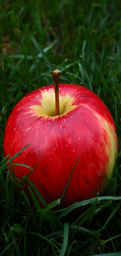

In [6]:
im_apl = Image.open((DATA_DIR / "subset" / "train" / "apple" / "Image_61.jpg"))
im_apl.to_thumb(256, 256)

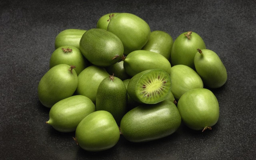

In [7]:
im_kwi = Image.open((DATA_DIR / "subset" / "train" / "kiwi" / "Image_88.jpg"))
im_kwi.to_thumb(256, 256)

## Train model

In [8]:
get_image_files_subset = partial(get_image_files, folders=["train", "validation"])

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


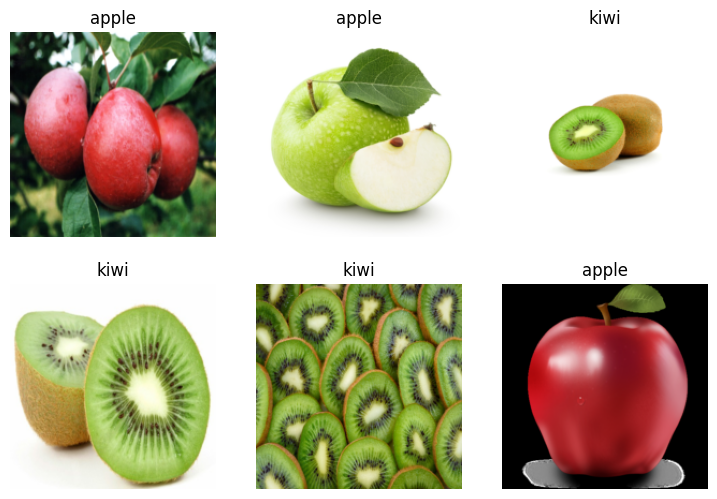

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files_subset, 
    splitter=GrandparentSplitter(train_name="train", valid_name="validation"),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(DATA_DIR / "subset", bs=32)

dls.show_batch(max_n=6)

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.992406,0.011388,0.000000,00:09


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.189475,0.003315,0.000000,00:08
1,0.133100,0.000591,0.000000,00:07
2,0.091135,0.000442,0.000000,00:09


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


The fine-tuning finished in 36 seconds and the error rate (1 - accuracy) is 0% from the first epoch. It indicates that the problem is too simple for the selected Resnet18 architecture.

In [19]:
fruit, _, probs = learn.predict(
    Image.open(
        "/content/drive/MyDrive/Colab Notebooks/data/fruits_veggies/subset/test/kiwi/Image_10.jpg"
    ).to_thumb(192, 192)
)
print(f"Fruit: {fruit.title()}")
print(f"Confidence: {(1 - probs[0]) * 100:.2f}%")

Fruit: Kiwi
Confidence: 100.00%


`learn.predict()` returns two outputs of interest:
1. The predicted class label for the input image.
2. The probability (confidence) of the predicted class. For a binary classification problem, the probability should be used as is for the first class and as (1 - probability) for the other class. For instance, for an image of apple in this instance, `probs` gives the probability, according to the model, of the image being an apple.